# Feature Engineering

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [2]:
df = pd.read_csv("../../data/processed/nba_ALL_SEASONS_MATCHED.csv")

In [3]:
# some of the easier ones

# making specific columns numeric if they aren't already
df['wl'] = df['wl'].map({'W': 1, 'L': 0})
df['whos_favored'] = df['whos_favored'].map({'home': 1, 'away': 0})

# theres some weirdness with the playin games, treating those games as playoffs
df.loc[(df['regular'] == False) & (df['playoffs'] == False), 'playoffs'] = True
df['part_of_season'] = df.apply(lambda row: 'playoffs' if row['playoffs'] else 'regular' , axis=1)

# making the spread in each line relative to the team
df['spread'] = df.apply(lambda row: row['spread'] if row['whos_favored'] == 1 else -row['spread'], axis=1)

# making the date column a datetime object
df['date'] = pd.to_datetime(df['date'])

# dropping columns that won't be used
df = df.drop(columns=['game_id', 'regular', 'playoffs', 'whos_favored'])

df = df.rename(columns={'team_abbreviation': 'team'})

In [4]:
# Now time to make new features

# rolling averages for last 5, 10, 20 games for points, assists, rebounds
df = df.sort_values(by=['team', 'date'])
for window in [5, 10, 20]:
    df[f'pts_avg_last_{window}'] = df.groupby('team')['pts'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    df[f'ast_avg_last_{window}'] = df.groupby('team')['ast'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    df[f'reb_avg_last_{window}'] = df.groupby('team')['reb'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))

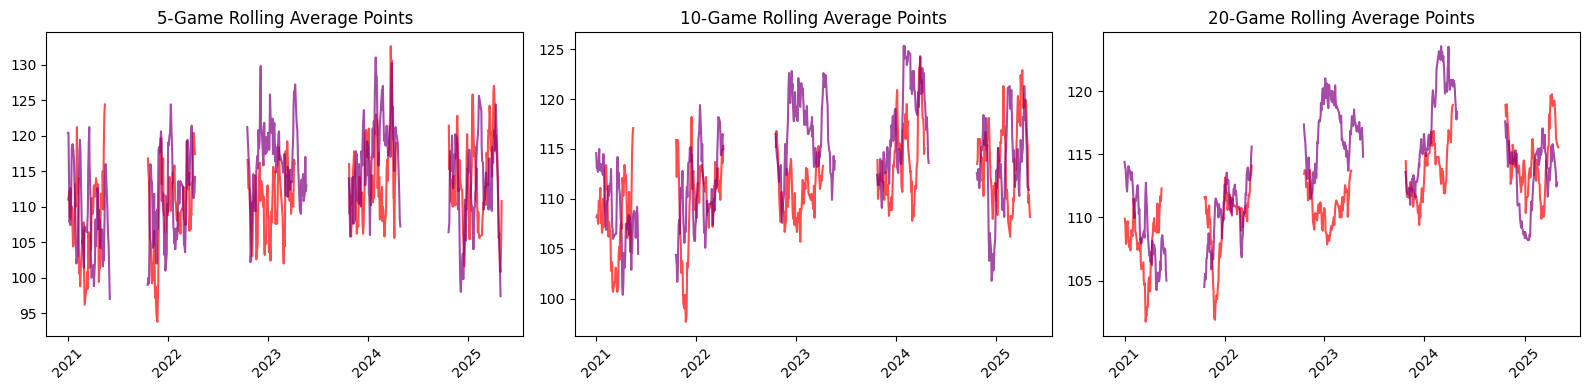

In [ ]:
plt.subplots(figsize=(16, 4))
plt.gca().set_axis_off()
start_date = pd.Timestamp('2021-01-01')
plt.subplot(1,3,1)


def plot_with_gaps(ax, dates, values, **kwargs):
    # Convert dates to numbers for easier diff calculation
    dates_num = date2num(dates)
    # Find indices where the gap is more than 10 days
    gap_idx = (dates_num[1:] - dates_num[:-1]) > 10
    # Always start with 0
    segments = [0] + list((gap_idx.nonzero()[0] + 1)) + [len(dates)]
    # Plot each segment separately
    for i in range(len(segments) - 1):
        idx_start, idx_end = segments[i], segments[i+1]
        ax.plot(dates[idx_start:idx_end], values[idx_start:idx_end], **kwargs)

ax = plt.gca()
plot_with_gaps(
    ax,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['pts_avg_last_5'].values,
    color='red', label='HOU', alpha=0.7
)
plot_with_gaps(
    ax,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['pts_avg_last_5'].values,
    color='purple', label='LAL', alpha=0.7
)
plt.xticks(
    ticks=pd.date_range(start=start_date, end=df['date'].max(), freq='YS'),
    labels=[d.strftime('%Y') for d in pd.date_range(start=start_date, end=df['date'].max(), freq='YS')],
    rotation=45
)
plt.title('5-Game Rolling Average Points')

plt.subplot(1,3,2)
ax = plt.gca()
plot_with_gaps(
    ax,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['pts_avg_last_10'].values,
    color='red', label='HOU', alpha=0.7
)
plot_with_gaps(
    ax,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['pts_avg_last_10'].values,
    color='purple', label='LAL', alpha=0.7
)
plt.xticks(
    ticks=pd.date_range(start=start_date, end=df['date'].max(), freq='YS'),
    labels=[d.strftime('%Y') for d in pd.date_range(start=start_date, end=df['date'].max(), freq='YS')],
    rotation=45
)
plt.title('10-Game Rolling Average Points')

plt.subplot(1,3,3)
ax = plt.gca()
plot_with_gaps(
    ax,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'HOU') & (df['date'] >= start_date)]['pts_avg_last_20'].values,
    color='red', label='HOU', alpha=0.7
)
plot_with_gaps(
    ax,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['date'].values,
    df[(df['team'] == 'LAL') & (df['date'] >= start_date)]['pts_avg_last_20'].values,
    color='purple', label='LAL', alpha=0.7
)
plt.xticks(
    ticks=pd.date_range(start=start_date, end=df['date'].max(), freq='YS'),
    labels=[d.strftime('%Y') for d in pd.date_range(start=start_date, end=df['date'].max(), freq='YS')],
    rotation=45
)
plt.title('20-Game Rolling Average Points')

plt.tight_layout()
plt.show()